In [1]:
'''
__author__ = 'Alex Cheng'
Python集成方法工具包解决分类问题：梯度提升法 处理水雷二分类问题
ensemble: RandomForestClassifier,
回归：分割点质量是有平方误差和（mse）
分类：误分类指标，ROC曲线，误分类率
predict,predic_proba,predict_log_proba

梯度提升算法会过拟合，持续跟踪AUC最佳值，其最佳值生成ROC曲线，fpr,tpr等
决策树数目的增加就等同于在梯度下降中采取了更多步骤，每一步就意味着又训练了一个决策树

'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve,auc,roc_auc_score,mean_squared_error
from math import sqrt
import random

In [3]:
path = 'd:/input/jobs/'
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
             "undocumented/connectionist-bench/sonar/sonar.all-data")
df = pd.read_csv(target_url,header=None,prefix="V")
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [4]:
# 原始数组
xList  = np.array(df.iloc[:,:-1]) # 属性数组
#labels = [i for i in df.iloc[:,-1]] # 最后一列就是label

labels = []
for label in df.iloc[:,-1]: # 分类问题，标签数值化
    if(label == 'M'): # 对df迭代时是案列的
        labels.append(1.0)
    else:
        labels.append(0.0)

names = df.columns


# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# RandomForest 要求数据为np.array格式
x = np.array(xList)
y = np.array(labels)
names = np.array(df.columns)

# model_selection
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=0.30,random_state=828)

Best AUC 0.9290060851926978
number of Trees for best AUC:  1691


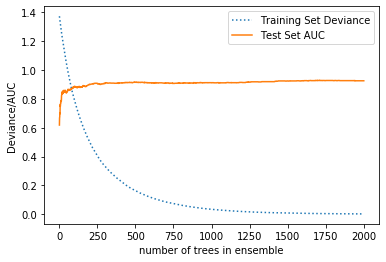

In [37]:
nEst = 2000
depth = 3
learnRate = 0.007
maxFeatures = 20 # 随机森林作为基学习器，GB有点过拟合
rockGB = ensemble.GradientBoostingClassifier(n_estimators=nEst,max_depth=depth,
            learning_rate=learnRate,max_features=maxFeatures)
rockGB.fit(xTrain,yTrain)
#rockGB.decision_function(xTrain) # 梯度提升分类器实际上市回归决策树的集合

auc = []
aucBest = 0.0
pred = rockGB.staged_decision_function(xTest) # 逐步增加树提升
for p in pred:
    auc_ = roc_auc_score(yTest,p) # auc
    auc.append(auc_)
    
    if auc_ > aucBest:
        aucBest = auc_
        pBest = p
    
idxBest = auc.index(max(auc))
print("Best AUC",auc[idxBest])
print("number of Trees for best AUC: ",idxBest)

# 训练集deviance和测试集的auc vs trees
plt.figure()
plt.plot(range(1,nEst+1),rockGB.train_score_,label='Training Set Deviance', linestyle=':')
plt.plot(range(1,nEst+1),auc,label='Test Set AUC')
plt.legend(loc='upper right')
plt.xlabel('number of trees in ensemble')
plt.ylabel('Deviance/AUC')
plt.show()

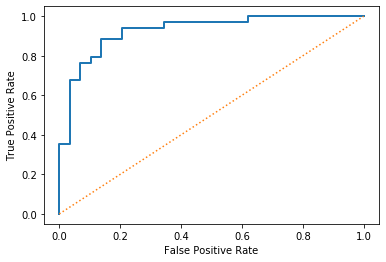

In [31]:
fpr,tpr,thresh = roc_curve(yTest,list(pBest)) # 注意GB预知没有落在（0,1）
ctClass = [i * 0.01 for i in range(101)]

plt.plot(fpr,tpr,linewidth=2)
plt.plot(ctClass,ctClass,linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [32]:
print(yTest[:5],pBest[:5])

[1. 1. 1. 0. 0.] [[ 3.57054428]
 [ 5.17883154]
 [ 2.84316485]
 [-1.01410007]
 [-0.92355085]]


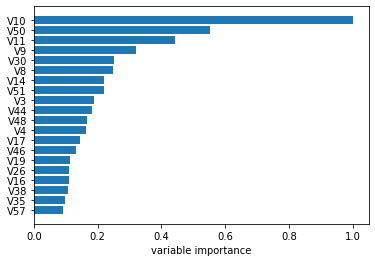

In [33]:
# 特征重要性,top30
featImportance = rockGB.feature_importances_
featImportance = featImportance / featImportance.max()
#print(len(featImportance))
idxSorted = np.argsort(featImportance)[40:] # 后面最大60-40个
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos,featImportance[idxSorted], align='center') # 水平柱状图
plt.yticks(barPos, names[idxSorted]) # np.array的数组可以[]取值
plt.xlabel('variable importance')
#plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.1)
plt.show()

In [34]:
# 计算confusion matrix, 注意，GBM预测不会再(0,1)范围
idx25 = int(len(thresh) * 0.25)
idx50 = int(len(thresh) * 0.50)
idx75 = int(len(thresh) * 0.75)

# 
totalPts = len(yTest)
P = sum(yTest) # 正例数
N = totalPts - P
print('confusion matrics for different threshold values')
# 可以看到 threshold值是递减的

#25th
TP = tpr[idx25] * P; TF = P - TP;
FN = fpr[idx25] * N; TN = N - FN
print('')
print('Threshold value = ',thresh[idx25])
print('TP=',TP/totalPts, 'FP=',TF/totalPts)
print('FN=',FN/totalPts, 'TN=',TN/totalPts)

#50th
TP = tpr[idx50] * P; TF = P - TP;
FN = fpr[idx50] * N; TN = N - FN
print('')
print('Threshold value = ',thresh[idx50])
print('TP=',TP/totalPts, 'FP=',TF/totalPts)
print('FN=',FN/totalPts, 'TN=',TN/totalPts)

#75th
TP = tpr[idx75] * P; TF = P - TP;
FN = fpr[idx75] * N; TN = N - FN
print('')
print('Threshold value = ',thresh[idx75])
print('TP=',TP/totalPts, 'FP=',TF/totalPts)
print('FN=',FN/totalPts, 'TN=',TN/totalPts)


confusion matrics for different threshold values

Threshold value =  2.8431648544044656
TP= 0.36507936507936506 FP= 0.1746031746031746
FN= 0.015873015873015872 TN= 0.4444444444444444

Threshold value =  2.2034189430618585
TP= 0.42857142857142855 FP= 0.1111111111111111
FN= 0.06349206349206349 TN= 0.3968253968253968

Threshold value =  -0.0017309425063885605
TP= 0.5079365079365079 FP= 0.031746031746031744
FN= 0.15873015873015872 TN= 0.30158730158730157
